In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR, PolynomialLR

import lightning as L
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger

import wandb
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from laplace import Laplace
from tqdm import tqdm

In [2]:
L.seed_everything(125)

Global seed set to 125


125

## Load Noisy Data

In [3]:
df = pd.read_parquet("./data.parquet")
df

,x,y
0,0.0000,20.239212
1,0.1001,19.173246
2,0.2002,19.736660
3,0.3003,19.289800
4,0.4004,19.614940
...,...,...
995,99.5996,13.279275
996,99.6997,14.038843
997,99.7998,13.098245
998,99.8999,13.125170


In [4]:
def f_true(x):
    return 20. * np.exp(-x / 10.) + x * np.exp(-x / 50.)

sigma_true = 0.5

domain = np.linspace(0, 100, 10000)
y_true = f_true(domain)

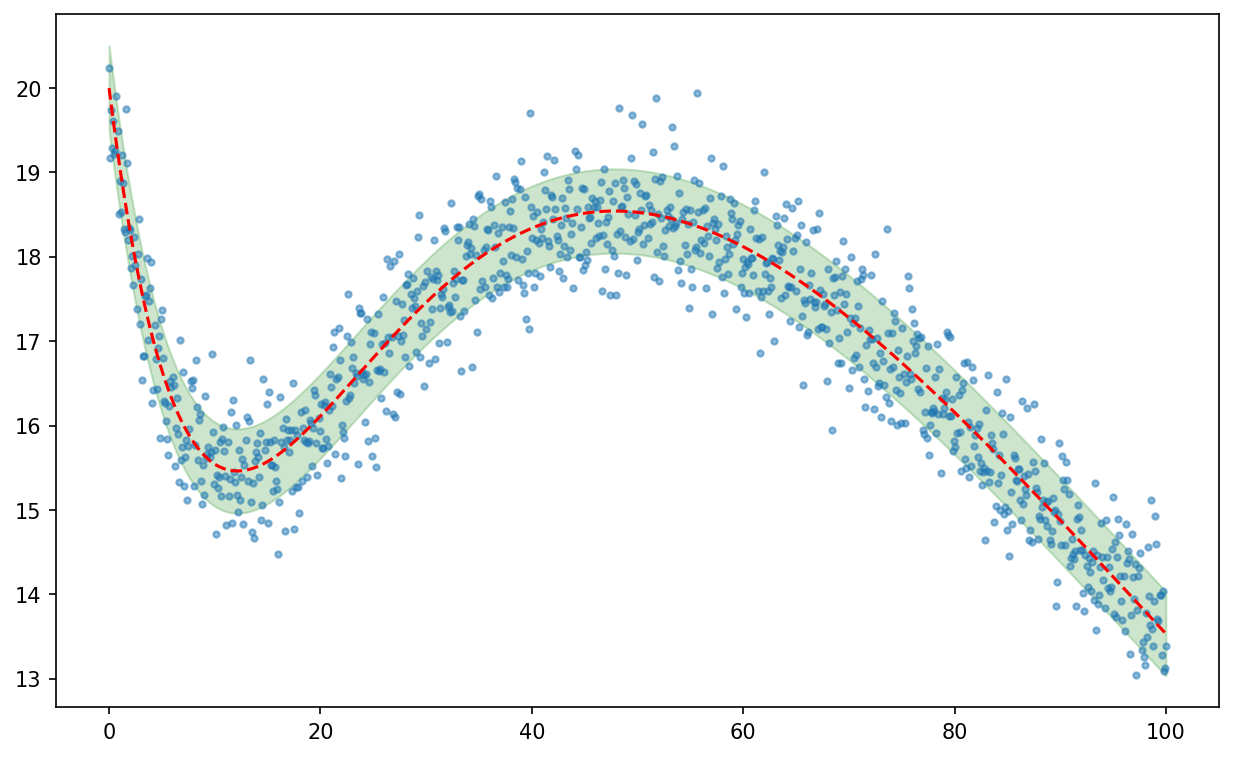

In [5]:
plt.figure(figsize=(10,6),dpi=150)
plt.plot(df['x'], df['y'], '.', alpha=0.5)
plt.plot(domain, y_true, 'r--')
plt.fill_between(domain, y_true + 0.5, y_true - 0.5, color='g', alpha=0.2)
plt.show()

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

print(df_train.shape)
print(df_test.shape)

(800, 2)
(200, 2)


In [7]:
df_train = df_train.sort_values(by=['x'])
df_test  = df_test.sort_values(by=['x'])

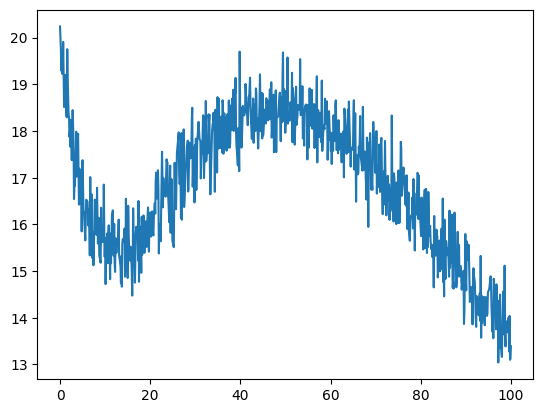

In [8]:
plt.plot(df_train['x'], df_train['y'])
plt.show()

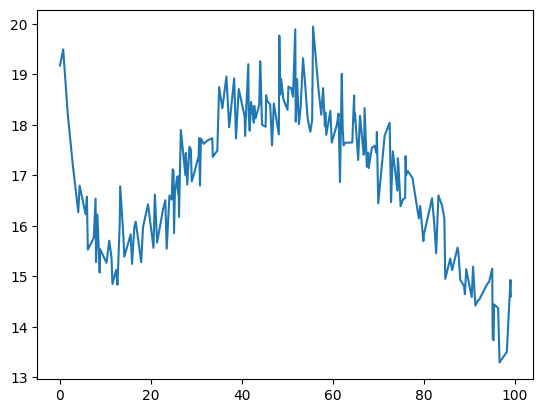

In [9]:
plt.plot(df_test['x'], df_test['y'])
plt.show()

In [10]:
scaler = RobustScaler()

scaler.fit(df_train)

df_train = scaler.transform(df_train)
df_test  = scaler.transform(df_test)

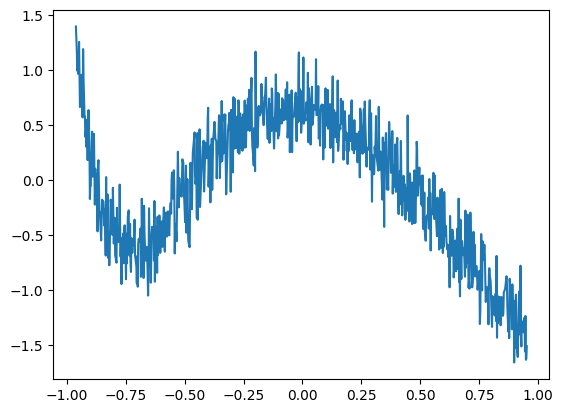

In [11]:
plt.plot(df_train[:,0], df_train[:,1])
plt.show()

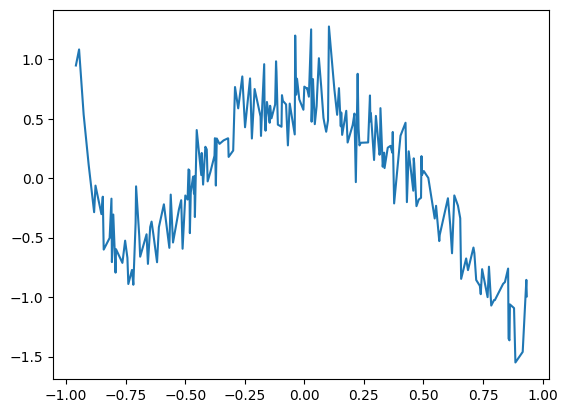

In [12]:
plt.plot(df_test[:,0], df_test[:,1])
plt.show()

In [13]:
class NoisyData(Dataset):
    def __init__(self, df):
        x = df[:,0]
        y = df[:,1]
        self.x = torch.tensor(x, dtype=torch.float32).reshape((-1,1))
        self.y = torch.tensor(y, dtype=torch.float32).reshape((-1,1))

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [14]:
ds_train = NoisyData(df_train)
ds_test  = NoisyData(df_test)

In [15]:
ds_train[:10]

(tensor([[-0.9608],
         [-0.9569],
         [-0.9550],
         [-0.9531],
         [-0.9512],
         [-0.9493],
         [-0.9474],
         [-0.9435],
         [-0.9416],
         [-0.9397]]),
 tensor([[1.4001],
         [1.1868],
         [0.9971],
         [1.1351],
         [0.9692],
         [0.9821],
         [1.2597],
         [0.6673],
         [0.8319],
         [0.6777]]))

## Normal MLP

In [16]:
class MLP(L.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.lr          = hparams['learning_rate']
        self.batch       = hparams['batch_size']
        self.hidden_size = hparams['hidden_size']
        self.num_layers  = hparams['num_layers']
        self.epochs      = hparams['epochs']

        self.save_hyperparameters()

        net = []
        net.extend([
            nn.Linear(1, self.hidden_size),
            nn.GELU(approximate='tanh'),
            # nn.BatchNorm1d(self.hidden_size)
        ])
        for _ in range(self.num_layers):
            net.extend([
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(approximate='tanh'),
                # nn.BatchNorm1d(self.hidden_size)
            ])
        net.append(nn.Linear(self.hidden_size, 1))
        self.net = nn.Sequential(*net)
        self.loss_fn = nn.MSELoss()
    
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y, y_hat)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return {
            "optimizer": optimizer,
            # "lr_scheduler": {
            #     "scheduler": OneCycleLR(
            #         optimizer,
            #         max_lr = self.lr,
            #         epochs = self.epochs,
            #         steps_per_epoch = len(ds_train) // self.batch + 1,
            #     ),
            #     "interval": "step",
            #     "monitor": "val_loss",
            #     "strict": True,
            # }
            "lr_scheduler": {
                "scheduler": PolynomialLR(
                    optimizer,
                    total_iters = self.epochs,
                    power = 2.0
                ),
                "interval": "epoch",
                "monitor": "val_loss",
                "strict": True,
            }
        }

In [17]:
hparams = {
    'learning_rate': 1e-2,
    'batch_size': 32,
    'epochs': 500,
    'hidden_size': 16,
    'num_layers': 4
}

In [18]:
dl_train = DataLoader(ds_train, batch_size=hparams['batch_size'], shuffle=True)
dl_test  = DataLoader(ds_test, batch_size=hparams['batch_size'], shuffle=False)

In [19]:
# model = MLP(hparams)
# model

In [20]:
# summary(model, input_size=(hparams['batch_size'], 1))

In [21]:
# wandb_logger = WandbLogger(
#     project="Noisy_Regression"  
# )

In [22]:
# trainer = Trainer(
#     logger = wandb_logger,
#     max_epochs = hparams['epochs'],
#     devices=[0],
#     accelerator='auto',
#     enable_progress_bar=False,
#     callbacks=[
#         ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=3),
#         LearningRateMonitor(logging_interval="epoch"),
#     ]
# )

In [23]:
# trainer.fit(model, dl_train, dl_test)

In [24]:
import os, re

In [25]:
pretrained_id = '4dc48wy3'

In [26]:
# ckpt_dir = f"./Noisy_Regression/{wandb.run.id}/checkpoints/"
ckpt_dir = f"./Noisy_Regression/{pretrained_id}/checkpoints/"
regex    = re.compile('epoch=(\d+)-step=(\d+).ckpt')
candis   = []
for root, _, files in os.walk(ckpt_dir):
    for file in files:
        if regex.match(file):
            candis.append(root + file)

In [27]:
candis

['./Noisy_Regression/4dc48wy3/checkpoints/epoch=68-step=1725.ckpt',
 './Noisy_Regression/4dc48wy3/checkpoints/epoch=179-step=4500.ckpt',
 './Noisy_Regression/4dc48wy3/checkpoints/epoch=183-step=4600.ckpt']

In [28]:
best_model = MLP.load_from_checkpoint(candis[-1])
best_model

MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): GELU(approximate='tanh')
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): GELU(approximate='tanh')
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): GELU(approximate='tanh')
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): GELU(approximate='tanh')
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): GELU(approximate='tanh')
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

In [29]:
def decoder(model, dl):
    x_input = []
    y_input = []
    y_output = []

    for x, y in dl:
        x_input.extend(x.flatten())
        y_input.extend(y.flatten())

        x = x.to(model.device)
        y = y.to(model.device)

        y_hat = model(x)
        y_output.extend(y_hat.detach().cpu().numpy().flatten())

    return x_input, y_input, y_output

In [30]:
x_input, y_input, y_output = decoder(best_model, dl_train)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

X_data = scaler.inverse_transform(X_data)
X_hat  = scaler.inverse_transform(X_hat)

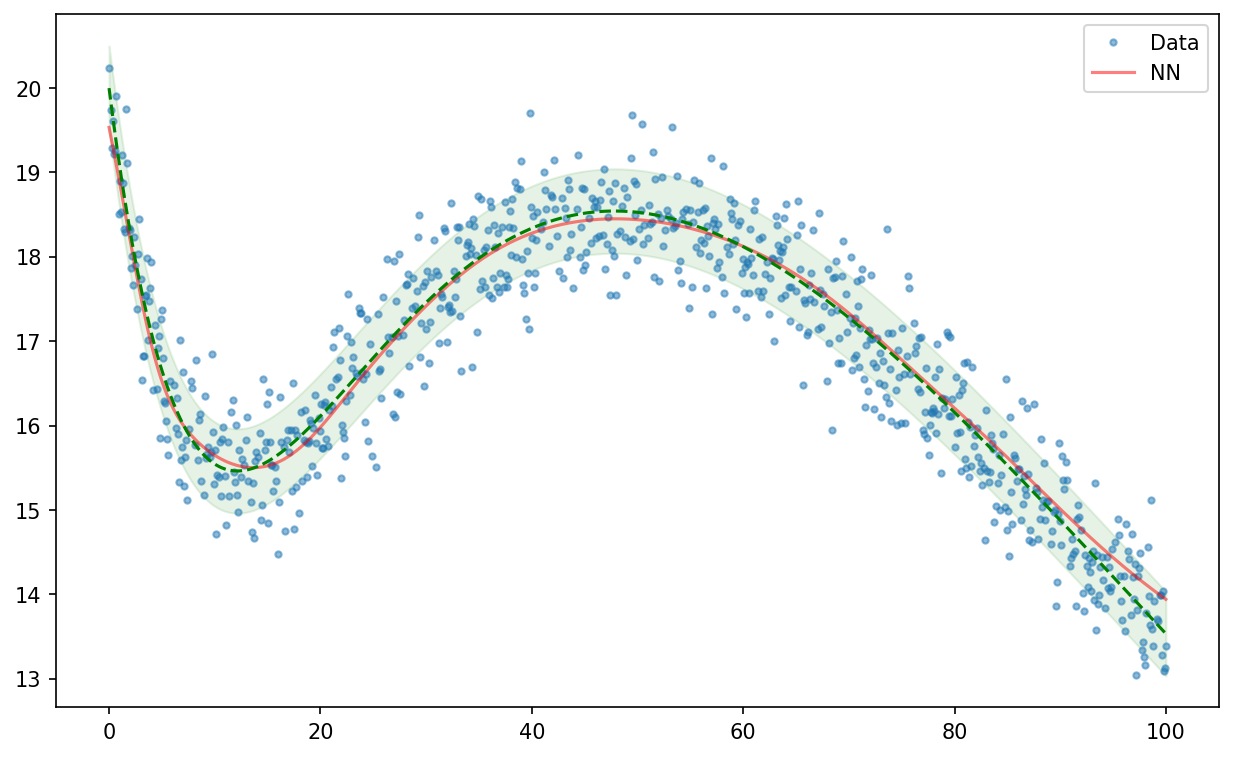

In [31]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.plot(domain, y_true, 'g--')
plt.fill_between(domain, y_true + 0.5, y_true - 0.5, color='g', alpha=0.1)
plt.legend()
plt.show()

In [32]:
x_input, y_input, y_output = decoder(best_model, dl_test)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat = np.column_stack([x_input, y_output])
X_hat = X_hat[X_hat[:,0].argsort()]

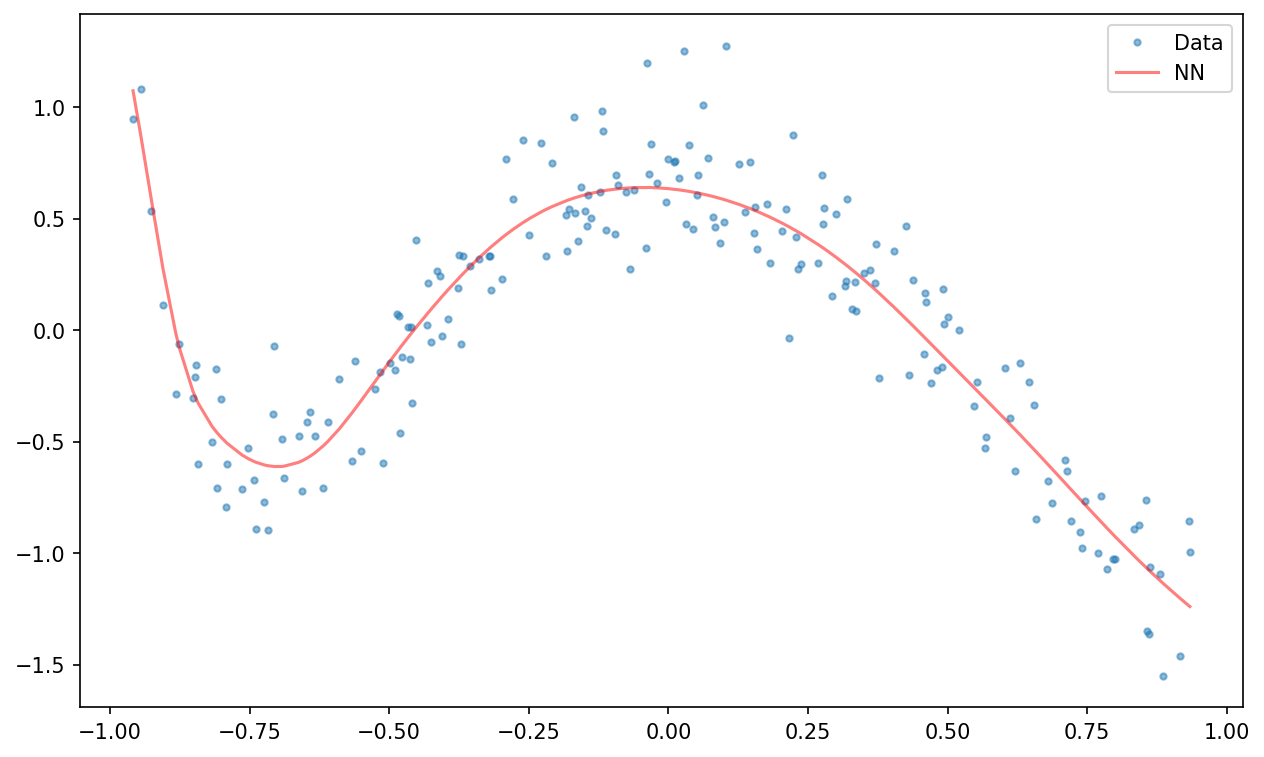

In [33]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.legend()
plt.show()

## Laplace approximation

In [34]:
la = Laplace(
    best_model, 
    'regression',
    subset_of_weights='all',
    hessian_structure='full'
)

In [35]:
la.fit(dl_train)

/home/xteca/Documents/Project/Machine_Learning/Noisy_Regression/.venv/lib/python3.11/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.MLP'> although the module has parameters
  warnings.warn(


In [36]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-2)
pbar = tqdm(range(1000), total=1000, desc='Description', leave=False)
for i in pbar:
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    neg_loss = neg_marglik.item()
    pbar.set_description(f"neg_loss: {neg_loss}")

In [37]:
def decoder_laplace(model, la, dl):
    x_input = []
    y_input = []
    y_output = []
    y_std = []

    for x, y in dl:
        x_input.extend(x.flatten())
        y_input.extend(y.flatten())

        x = x.to(model.device)
        y = y.to(model.device)

        f_mu, f_var = la(x)
        f_mu = f_mu.detach().cpu().numpy().flatten()
        f_sigma = f_var.sqrt().detach().cpu().numpy().flatten()
        pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)
        y_output.extend(f_mu)
        y_std.extend(pred_std)

    return x_input, y_input, y_output, y_std

In [38]:
x_input, y_input, y_output, y_std = decoder_laplace(best_model, la, dl_train)

X_data = np.column_stack([x_input, y_input])
X_data = X_data[X_data[:,0].argsort()]

X_hat0 = np.column_stack([x_input, y_output, y_std])
X_hat0 = X_hat0[X_hat0[:,0].argsort()]

X_hat = X_hat0[:, 0:2]
X_std = X_hat0[:,2] * scaler.scale_[1] # Inverse scaling

X_data = scaler.inverse_transform(X_data)
X_hat  = scaler.inverse_transform(X_hat)

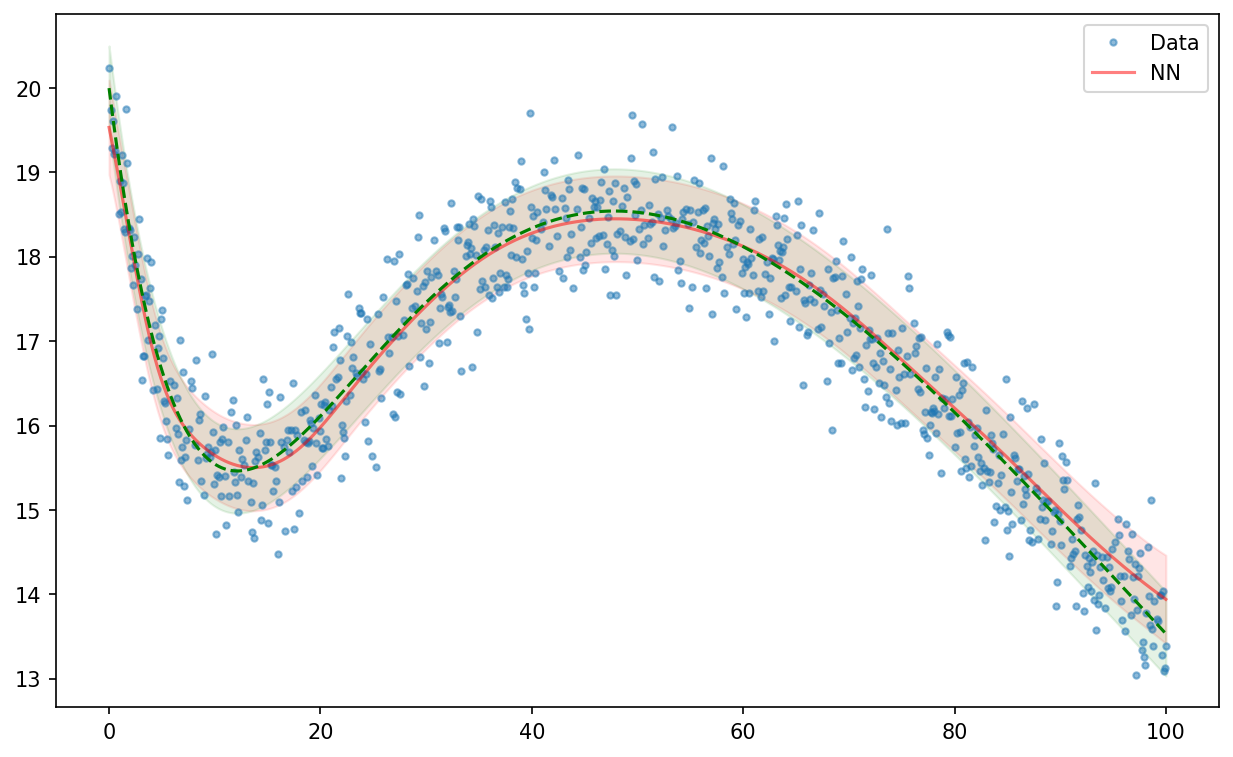

In [39]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(X_hat[:,0], X_hat[:,1], 'r-', label='NN', alpha=0.5)
plt.fill_between(X_hat[:,0], X_hat[:,1] - X_std, X_hat[:,1] + X_std, color='r', alpha=0.1)
plt.plot(domain, y_true, 'g--')
plt.fill_between(domain, y_true + 0.5, y_true - 0.5, color='g', alpha=0.1)
plt.legend()
plt.show()

In [40]:
x_test = torch.linspace(-1.1, 1.1, 100).reshape((-1,1))
y_test = best_model(x_test.to(best_model.device))


mu_test, var_test = la(x_test.to(best_model.device))
mu_test = mu_test.detach().cpu().numpy().flatten()
std_test = var_test.sqrt().detach().cpu().numpy().flatten()
std_test = np.sqrt(std_test**2 + la.sigma_noise.item()**2)

x_test = x_test.detach().cpu().numpy().flatten()
y_test = y_test.detach().cpu().numpy().flatten()

xy_test = scaler.inverse_transform(np.column_stack([x_test, mu_test]))
x_test  = xy_test[:,0]
y_test  = xy_test[:,1]
std_test = std_test * scaler.scale_[1]

/home/xteca/Documents/Project/Machine_Learning/Noisy_Regression/.venv/lib/python3.11/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class '__main__.MLP'> although the module has parameters
  warnings.warn(


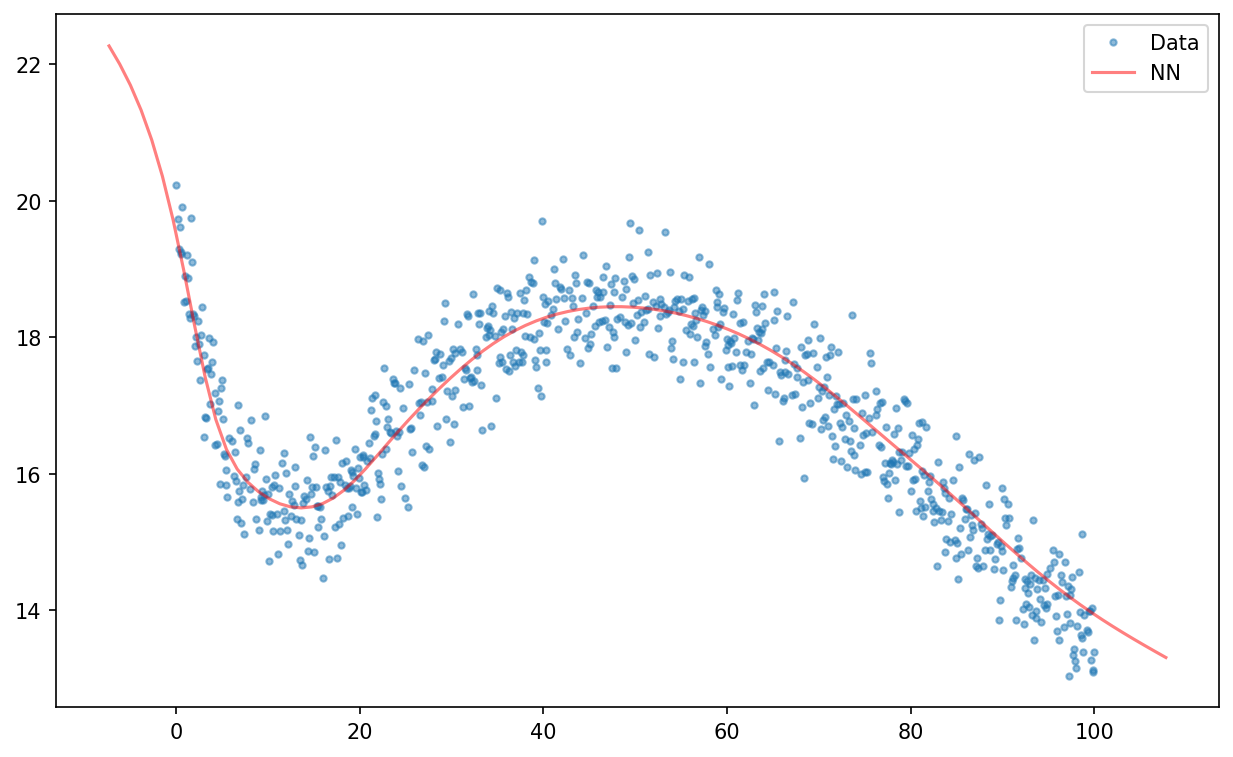

In [41]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(x_test, y_test, 'r-', label='NN', alpha=0.5)
# plt.fill_between(X_hat[:,0], X_hat[:,1] - X_hat[:,2], X_hat[:,1] + X_hat[:,2], color='r', alpha=0.2)
plt.legend()
plt.show()

In [42]:
y_new = f_true(x_test)

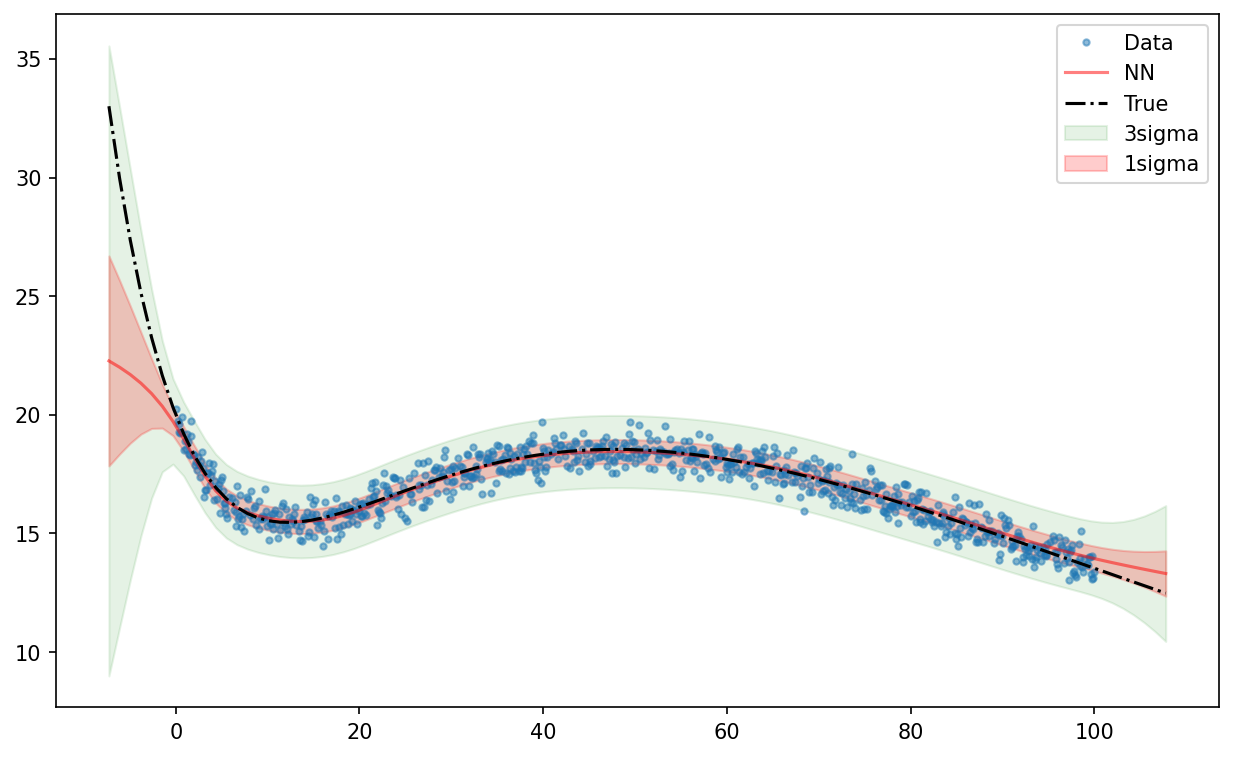

In [43]:
plt.figure(figsize=(10,6), dpi=150)
plt.plot(X_data[:,0], X_data[:,1], '.', label='Data', alpha=0.5)
plt.plot(x_test, y_test, 'r-', label='NN', alpha=0.5)
plt.plot(x_test, y_new, 'k-.', label='True')
plt.fill_between(x_test, y_test-3*std_test, y_test+3*std_test, color='g', alpha=0.1, label='3sigma')
plt.fill_between(x_test, y_test-std_test, y_test+std_test, color='r', alpha=0.2, label='1sigma')
plt.legend()
plt.show()